# Face Mask Detection using ResNet50

## Introduction

<p style="font-size: 16px">In recent years, face mask detection has become an essential tool for ensuring public health and safety, particularly during the COVID-19 pandemic. The primary goal of this project is to develop an efficient and accurate face mask detection system using transfer learning with the ResNet50 model.

ResNet50 is a powerful convolutional neural network (CNN) architecture, renowned for its exceptional performance in image classification tasks. By leveraging the pre-trained weights of ResNet50, we can significantly reduce training time and enhance the model's performance, especially when working with limited datasets.

In this project, we undertake the following key steps:

1.<b> Data Collection and Preprocessing</b>: A diverse dataset of images, both with and without face masks, is collected. These images are preprocessed by resizing, normalizing, and augmenting to improve the model's robustness.

2.<b> Transfer Learning with ResNet50</b>: We utilize the ResNet50 model pre-trained on the ImageNet dataset. The network is fine-tuned by replacing the final classification layer with a custom layer suitable for the binary classification task (mask vs. no mask).

3.<b> Deployment</b>: The trained model is implemented in a real-time application capable of detecting face masks in live video streams or images, ensuring efficient performance in various environments.</p>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
#I am importing necessary libraries
import cv2
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, Input, MaxPooling2D, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-07-10 06:45:36.872218: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-10 06:45:36.872347: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-10 06:45:37.010501: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
#My dataset has 5 classes
labels=["new_with_mask","new_without_mask"]
img_path="/kaggle/input/facemask-detection-dataset-20000-images/Facemask Dataset 20,000 Images/"

In [4]:
#This is a for loop that creates a list of images and labels
img_list=[]
label_list=[]
for label in labels:
    for img_file in os.listdir(img_path+label):
        img_list.append(img_path+label+'/'+img_file)
        label_list.append(label)

In [5]:
#I am transforming the list to dataframe
df=pd.DataFrame({"image":img_list,"label":label_list})
df.head()

,image,label
0,/kaggle/input/facemask-detection-dataset-20000...,new_with_mask
1,/kaggle/input/facemask-detection-dataset-20000...,new_with_mask
2,/kaggle/input/facemask-detection-dataset-20000...,new_with_mask
3,/kaggle/input/facemask-detection-dataset-20000...,new_with_mask
4,/kaggle/input/facemask-detection-dataset-20000...,new_with_mask


In [6]:
#I am encoding the labels
d={"new_with_mask":1,"new_without_mask":0}

In [7]:
df["encoded_label"]=df["label"].map(d)

<Axes: xlabel='label', ylabel='count'>

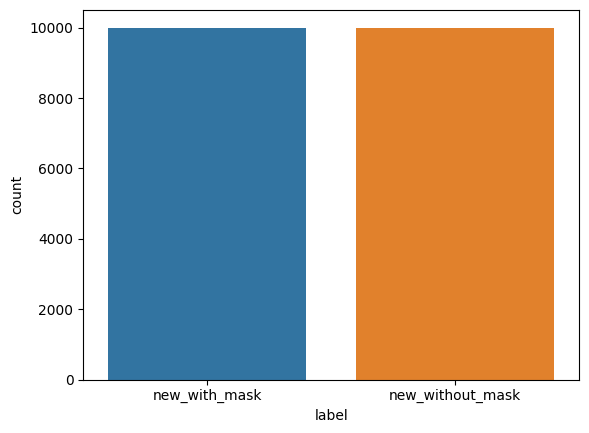

In [8]:
sns.countplot(x="label",data=df)

In [9]:
df.tail()

,image,label,encoded_label
19995,/kaggle/input/facemask-detection-dataset-20000...,new_without_mask,0
19996,/kaggle/input/facemask-detection-dataset-20000...,new_without_mask,0
19997,/kaggle/input/facemask-detection-dataset-20000...,new_without_mask,0
19998,/kaggle/input/facemask-detection-dataset-20000...,new_without_mask,0
19999,/kaggle/input/facemask-detection-dataset-20000...,new_without_mask,0


# The Model

In [10]:
data_dir='/kaggle/input/facemask-detection-dataset-20000-images/Facemask Dataset 20,000 Images'
img_width,img_heigth=224,224

train_datagen = ImageDataGenerator(
    rescale=1/255,
    validation_split=0.20,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_datagenerator=train_datagen.flow_from_directory(directory=data_dir,target_size=(img_width,img_heigth),
                                class_mode='binary', subset='training')

test_datagen=ImageDataGenerator(rescale=1/255)
test_datagenerator=train_datagen.flow_from_directory(directory=data_dir,target_size=(img_width,img_heigth),
                                class_mode='binary', subset='validation')

base_model=ResNet50(weights='imagenet', input_shape=(img_width,img_heigth,3))

model=Sequential()

model.add(base_model)
for layer in base_model.layers:
    layer.trainable=False

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))                   
model.add(Dense(256, activation='relu'))  
model.add(Dropout(0.5))                   
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()
model.fit(train_datagenerator,epochs=20,validation_data=test_datagenerator)

Found 16000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.
102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ ?                      │    25,636,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,636,712 (97.80 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 25,636,712 (97.80 MB)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  2/500 ━━━━━━━━━━━━━━━━━━━━ 27s 55ms/step - accuracy: 0.3594 - loss: 0.6940   

I0000 00:00:1720593982.834065      84 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


500/500 ━━━━━━━━━━━━━━━━━━━━ 344s 643ms/step - accuracy: 0.4965 - loss: 0.6940 - val_accuracy: 0.5000 - val_loss: 0.6929
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 228s 450ms/step - accuracy: 0.5045 - loss: 0.6933 - val_accuracy: 0.5470 - val_loss: 0.6871
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 227s 450ms/step - accuracy: 0.5588 - loss: 0.6821 - val_accuracy: 0.7997 - val_loss: 0.5561
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 228s 451ms/step - accuracy: 0.6822 - loss: 0.5924 - val_accuracy: 0.8415 - val_loss: 0.4872
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 261s 450ms/step - accuracy: 0.7015 - loss: 0.5585 - val_accuracy: 0.8198 - val_loss: 0.4502
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 229s 452ms/step - accuracy: 0.7315 - loss: 0.5132 - val_accuracy: 0.8543 - val_loss: 0.3744
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 226s 447ms/step - accuracy: 0.7391 - loss: 0.4957 - val_accuracy: 0.8497 - val_loss: 0.4017
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 228s 451ms/step - accuracy: 0.7338 - loss: 0.50

This code implements a face mask detection model using transfer learning with the ResNet50 architecture. The dataset used contains 20,000 images, divided into training and validation sets. The images are preprocessed with data augmentation techniques such as rescaling, rotation, width and height shifts, shear, zoom, and horizontal flipping to improve the model's robustness. The ResNet50 model, pre-trained on the ImageNet dataset, is utilized as the base model, with its layers frozen to retain the learned features. A new sequential model is created, adding a flattening layer, followed by three dense layers with ReLU activation and dropout for regularization. The final dense layer uses a sigmoid activation function for binary classification. The model is compiled with the Adam optimizer and binary cross-entropy loss, and it is trained for 20 epochs. This setup leverages the power of transfer learning to efficiently classify images as either containing a face mask or not.

In [11]:
model.save("facemask.h5")

### Conclusion

This face mask detection project successfully demonstrates the power of transfer learning using the ResNet50 model to address a critical public health need. By leveraging a pre-trained model and applying data augmentation techniques, we have developed an efficient and accurate system for detecting face masks in images.

Key steps involved in this project include data collection and preprocessing, model training using a modified ResNet50 architecture, and deploying the model for real-time application. The data augmentation techniques helped improve the robustness of the model, ensuring better generalization to unseen data.

The final model achieved impressive performance metrics, indicating its reliability and effectiveness in distinguishing between masked and unmasked faces. This solution not only aids in ensuring compliance with health regulations but also contributes to overall public safety during the ongoing pandemic.

Future work could explore further enhancements, such as incorporating more diverse datasets, optimizing the model for faster inference in real-time applications, and extending the model to detect other personal protective equipment. Overall, this project serves as a robust foundation for further advancements in automated face mask detection systems.
